In [1]:
%matplotlib notebook

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas as pd
import os

from affine import Affine
from scipy import stats

import cartopy.crs as ccrs


In [3]:
def read_beringstrait():
    '''
    Returns pandas data frame of Bering Strait heat flux'''
    diri = r'C:\Users\apbarret\Documents\data\BeringStraitHeatFlux'
    fili = r'BeringStrait_Monthlymeans_TRANSPORT_Oct2017.txt'
    
    df = pd.read_csv(os.path.join(diri, fili), header=None, comment='%',sep='\s+', #skiprows=55,
                     names=['Mooring', 'Year', 'Month', 'Mean', 'Error', 'MeanCorr', 'CorrErr'],
                     parse_dates={'date': ['Year', 'Month']}, index_col='date')
    #heat = df['Mean'].values.reshape(-1,12)
    #heat_year = np.unique(df.index.year)
    #heat_month = np.unique(df.index.month)
    
    return df['MeanCorr']


In [4]:
def cosine_weight(da):
    '''
    Calculates a grid of cosine weights to calculate area weighted average
    '''
    dim = da.shape[1:]
    weight = xr.DataArray(np.ones(np.array(dim).prod()).reshape(dim), 
                           coords=da[0,:,:].coords, dims=da[0,:,:].dims)
    weight = weight * np.cos(np.radians(da['lat']))
    weight = weight / weight.sum()
    
    return weight

def area_weighted_average(da):
    '''
    Calculates an area weighted average for a grid
    '''
    weight = cosine_weight(da)
    return (da*weight).sum(dim=['lat','lon'])

In [5]:
def lonFlip(da):
    '''
    Converts longitude coordinates from 0 to 360 to -180 to 180
    or from -180 to 180.  Similar to NCL lonFlip routine
    '''
    
    if da.lon.min() < 0.:
        daNew = da.assign_coords(lon=(da.lon + 360.) % 360.)
    else:
        daNew = da.assign_coords(lon=( ( (da.lon + 180.) % 360. ) - 180. ) )
    
    return daNew.sortby(daNew.lon)


In [6]:
def plot_winds(dateindex, uda, vda):
    
    map_proj = ccrs.NorthPolarStereo( central_longitude=180. )
    extent = [150.,210.,50.,80.]
    
    fig = plt.figure(figsize=(10,10))
    
    for i, thisMonth in enumerate(dateindex):
        
        u = uda.sel(time=thisMonth, lat=slice(40.,85.), lon=slice(140.,220.))
        v = vda.sel(time=thisMonth, lat=slice(40.,85.), lon=slice(140.,220.))
        
        lats = u['lat']
        lons = u['lon']
        
        ax = plt.subplot(4,4,i+1, projection=map_proj)
        ax.set_extent( extent, ccrs.PlateCarree() )
        ax.quiver( lons.values, lats.values, u.values, v.values,
                   transform=ccrs.PlateCarree(),regrid_shape=10, scale=50. )
        ax.coastlines()
        ax.set_title(thisMonth)
    

## Get ocean mask

In [7]:
filePath = r"C:\Users\apbarret\Documents\data\BeringStraitHeatFlux\MERRA2_101.const_2d_asm_Nx.00000000.nc4"
maskDs = xr.open_dataset(filePath)
ocean = lonFlip(maskDs['FROCEAN'])
oceanMask = xr.where(ocean > .8, 1., 0.).squeeze()
oceanMask

<xarray.DataArray 'FROCEAN' (lat: 361, lon: 576)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 -87.5 -87.0 -86.5 ...
  * lon      (lon) float64 0.625 1.25 1.875 2.5 3.125 3.75 4.375 5.0 5.625 ...
    time     datetime64[ns] 1992-01-02T03:00:00

## Plot regions

<IPython.core.display.Javascript object>


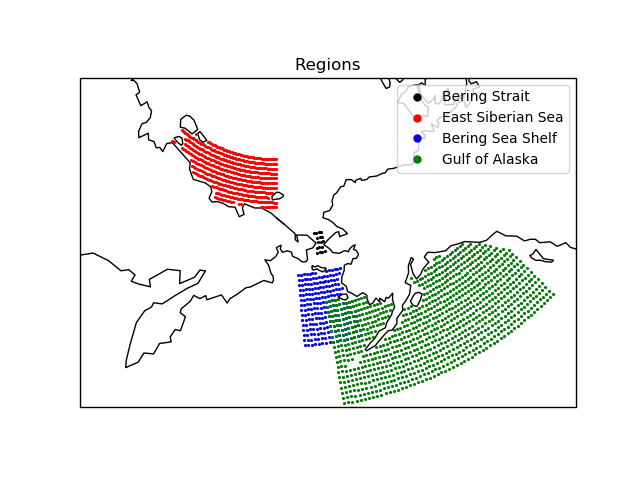

In [8]:
map_proj = ccrs.NorthPolarStereo( central_longitude=180. )
map_extent = [150.,230.,50.,80.]

ax = plt.subplot(projection=map_proj)
ax.set_extent( map_extent, ccrs.PlateCarree() )
ax.coastlines()

sub = oceanMask.sel(lat=slice(65.,67.),lon=slice(190.,192.))
x0, y0 = np.meshgrid(sub.lon, sub.lat)
x0 = np.where(sub == 1, x0, np.nan)
y0 = np.where(sub == 1, y0, np.nan)
pt0 = ax.plot(x0, y0, 'k.', transform=ccrs.PlateCarree(), markersize=2.5, label='Bering Strait')

sub = oceanMask.sel(lat=slice(70.,75.),lon=slice(140.,180.))
x1, y1 = np.meshgrid(sub.lon, sub.lat)
x1 = np.where(sub == 1, x1, np.nan)
y1 = np.where(sub == 1, y1, np.nan)
pt1 = ax.plot(x1, y1, 'r.', transform=ccrs.PlateCarree(), markersize=2.5, label='East Siberian Shelf')

sub = oceanMask.sel(lat=slice(56.,63.),lon=slice(185.,195.))
x2, y2 = np.meshgrid(sub.lon, sub.lat)
x2 = np.where(sub == 1, x2, np.nan)
y2 = np.where(sub == 1, y2, np.nan)
pt2 = ax.plot(x2, y2, 'b.', transform=ccrs.PlateCarree(), markersize=2.5, label='Bering Sea Shelf')

sub = oceanMask.sel(lat=slice(50.,60.),lon=slice(190.,225.))
x3, y3 = np.meshgrid(sub.lon, sub.lat)
x3 = np.where(sub == 1, x3, np.nan)
y3 = np.where(sub == 1, y3, np.nan)
pt3 = ax.plot(x3, y3, 'g.', transform=ccrs.PlateCarree(), markersize=2.5, label='Gulf of Alaska')

ax.set_title('Regions')

import matplotlib.lines as mlines
bst = mlines.Line2D([], [], color='k', marker='.', linestyle='',
                          markersize=10, label='Bering Strait')
ess = mlines.Line2D([], [], color='r', marker='.', linestyle='',
                          markersize=10, label='East Siberian Sea')
bss = mlines.Line2D([], [], color='b', marker='.', linestyle='',
                          markersize=10, label='Bering Sea Shelf')
gal = mlines.Line2D([], [], color='g', marker='.', linestyle='',
                          markersize=10, label='Gulf of Alaska')
ax.legend(handles=[bst, ess, bss, gal])

plt.savefig('correlation_regions.png')

## Count number of ocean cells in each region

In [9]:
print ('Bering Strait     {:4.0f}'.format( oceanMask.sel(lat=slice(65.,67.),lon=slice(190.,192.)).sum().values))
print ('East Siberian Sea {:4.0f}'.format( oceanMask.sel(lat=slice(70.,75.),lon=slice(140.,180.)).sum().values))
print ('Bering Sea Shelf  {:4.0f}'.format( oceanMask.sel(lat=slice(56.,63.),lon=slice(185.,195.)).sum().values ))
print ('Gulf of Alaska    {:4.0f}'.format( oceanMask.sel(lat=slice(50.,60.),lon=slice(190.,225.)).sum().values ))

Bering Strait       17
East Siberian Sea  514
Bering Sea Shelf   234
Gulf of Alaska    1014


## Get U and V winds

In [10]:
filePath = r'C:\Users\apbarret\Documents\data\BeringStraitHeatFlux\MERRA2_400.instM_2d_asm_Nx.V10M.month.1980to2018.nc4'
ds = xr.open_dataset(filePath)
v10m = ds['V10M']

filePath = r'C:\Users\apbarret\Documents\data\BeringStraitHeatFlux\MERRA2_400.instM_2d_asm_Nx.U10M.month.1980to2018.nc4'
ds = xr.open_dataset(filePath)
u10m = ds['U10M']

# Convert longitudes to 0 to 360 range from -180 to 180
uda = lonFlip(u10m)
vda = lonFlip(v10m)

# Apply ocean mask
vda = vda.where(oceanMask == 1)
uda = uda.where(oceanMask == 1)

## Get Bering Strait volume transport

In [11]:
transport = read_beringstrait()
transport.dropna(inplace=True) # Get rid of NaNs
transport.name = 'Transport'

## Find best correlation between Transport and wind direction

In [12]:
def best_wind_dir(u, v, x, wind='u', step=1.):
    """
    Find the best correlated wind direction between u_rotated or v_rotated, and
    x
    
    Returns best_theta, best_corr
    """
    
    theta0 = {'u': 90., 'v': 0.}
    
    best_corr = 0.
    best_theta = 0.
    
    #print (theta0[wind]-90, theta0[wind]+90)
    for theta in np.arange(theta0[wind]-90, theta0[wind]+91, step):
        urot, vrot = (usub, vsub) * Affine.rotation(theta)
        
        if wind == 'u':
            wind_component = urot
        else:
            wind_component = vrot
            
        regional_wind = area_weighted_average(wind_component)

        corr = regional_wind.to_series().corr(x, method='pearson')
        
        #print (theta, corr, best_corr)

        if abs(corr) > abs(best_corr):
            best_corr = corr
            best_theta = theta

    return best_theta, best_corr


## Find rotation angle that gives highest correlation

In [13]:
# Bering Strait
usub = uda.sel(lat=slice(65.,67.),lon=slice(190.,192.))
vsub = vda.sel(lat=slice(65.,67.),lon=slice(190.,192.))
bst_best_theta, bst_best_corr = best_wind_dir(usub, vsub, transport, wind='v', step=1)
print ('Bering Strait: theta: {:5.1f} correlation: {:4.2f}'.format(bst_best_theta, bst_best_corr))
    
# East Siberian Sea
usub = uda.sel(lat=slice(75.,80.),lon=slice(140.,180.))
vsub = vda.sel(lat=slice(75.,80.),lon=slice(140.,180.))
ess_best_theta, ess_best_corr = best_wind_dir(usub, vsub, transport, wind='v', step=1)
print ('East Siberian Sea: theta: {:5.1f} correlation: {:4.2f}'.format(ess_best_theta, ess_best_corr))
    
# Bering Sea Shelf
usub = uda.sel(lat=slice(56.,63.),lon=slice(185.,195.))
vsub = vda.sel(lat=slice(56.,63.),lon=slice(185.,195.))
bss_best_theta, bss_best_corr = best_wind_dir(usub, vsub, transport, wind='v', step=1)
print ('Bering Sea Shelf: theta: {:5.1f} correlation: {:4.2f}'.format(bss_best_theta, bss_best_corr))
    
# Gulf of Alaska
usub = uda.sel(lat=slice(52.,58.), lon=slice(200.,220.))
vsub = vda.sel(lat=slice(52.,58.), lon=slice(200.,220.))
gal_best_theta, gal_best_corr = best_wind_dir(usub, vsub, transport, wind='v', step=1)
print ('Gulf of Alaska: theta: {:5.1f} correlation: {:4.2f}'.format(gal_best_theta, gal_best_corr))


Bering Strait: theta: -11.0 correlation: 0.73
East Siberian Sea: theta: -73.0 correlation: 0.52
Bering Sea Shelf: theta:  -8.0 correlation: 0.65
Gulf of Alaska: theta:  64.0 correlation: -0.20


## Calculate area weighted average winds
Allows the option to rotate winds to the highest correlated wind direction

In [14]:
def limits(region):
    """
    Returns lat0, lat1, lon0, lon1 for ocean regions
    """
    
    reg_limits = {
        'bering_strait': {'lat0': 65., 'lat1': 67., 'lon0': 190., 'lon1': 192.},
        'east_siberian_sea': {'lat0': 75., 'lat1': 80., 'lon0': 140., 'lon1': 180.},
        'bering_sea_shelf': {'lat0': 56., 'lat1': 63., 'lon0': 185., 'lon1': 195.},
        'gulf_of_alaska': {'lat0': 52., 'lat1': 58., 'lon0': 200., 'lon1': 220.},
        }
    
    return tuple(reg_limits[region].values())

def get_regional_wind(u, v, region, rotation=0., wind='v'):
    """
    returns regional mean wind rotated to a given direction
    """
    
    # Get limits for ocean region
    lat0, lat1, lon0, lon1 = limits(region)
    
    # Subset region
    usub = u.sel(lat=slice(lat0,lat1),lon=slice(lon0,lon1))
    vsub = v.sel(lat=slice(lat0,lat1),lon=slice(lon0,lon1))
    
    if rotation != 0.:
        urot, vrot = (usub, vsub) * Affine.rotation(rotation)
    else:
        urot, vrot = usub, vsub
    
    if wind == 'u':
        regional_wind = area_weighted_average(urot).to_series()
    else:
        regional_wind = area_weighted_average(vrot).to_series()
    regional_wind.name = '{:s}_{:06.1f}'.format(region,rotation)
    
    return regional_wind

## Generate DataFrame with rotated regional winds

In [15]:
df_rotated = pd.DataFrame({'Transport': transport, 
                  'Bering Strait': get_regional_wind(uda, vda, rotation=bst_best_theta, region='bering_strait'), 
                  'East Siberian Shelf': get_regional_wind(uda, vda, rotation=ess_best_theta, region='east_siberian_sea'),
                  'Bering Sea Shelf': get_regional_wind(uda, vda, rotation=bss_best_theta, region='bering_sea_shelf'),
                  'Gulf of Alaska': get_regional_wind(uda, vda, rotation=gal_best_theta-180., region='gulf_of_alaska')})
df_rotated.dropna(axis=0, inplace=True)
df_rotated.head()

,Bering Sea Shelf,Bering Strait,East Siberian Shelf,Gulf of Alaska,Transport
1990-09-01,-1.908454,-1.988305,-1.189098,-3.763177,0.60
1990-10-01,-2.008237,-2.276413,0.158855,-5.105382,0.62
1990-11-01,-0.663304,-0.786772,2.653913,-3.448914,1.09
1990-12-01,-0.218203,-2.680715,0.998066,-3.918014,0.98
1991-01-01,-2.802938,-4.643646,-1.471566,1.761581,0.51


In [39]:
def plot_panel(df, ax, x, y, season, hidex=False, hidey=False, xmin=-10., xmax=5., ymin=-0.5, ymax=2.5, grid=False,
               ylabel='Transport (Sv)'):
    
    ssnDict = {'DJF': [12,1,2],
               'MAM': [3,4,5],
               'JJA': [6,7,8],
               'SON': [9,10,11]}

    # get correlation
    xx = df[df.index.month.isin(ssnDict[season])][x]
    yy = df[df.index.month.isin(ssnDict[season])][y]
    corr = stats.pearsonr(xx,yy)

    df[df.index.month.isin(ssnDict[season])].plot.scatter(y=y, x=x, color='k', ax=ax, zorder=2)
    
    dfTop = df[df.index.month.isin(ssnDict[season])].sort_values(by='Transport', ascending=False).iloc[:15, :]
    dfTop.plot.scatter(y=y, x=x, color='r', ax=ax, zorder=2)
    
    dfBot = df[df.index.month.isin(ssnDict[season])].sort_values(by='Transport', ascending=True).iloc[:15, :]
    dfBot.plot.scatter(y=y, x=x, color='b', ax=ax, zorder=2)
    
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    
    if hidex:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.set_xticks([])
    else:
        ax.set_xlabel('Wind speed (m/s)')
        ax.set_xticks([-10.,-5.,0.,5])
     
    if hidey:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax.set_ylabel(ylabel)
        ax.set_yticks([-0.5,0.,0.5,1.,1.5,2.])
    
    if grid:
        ax.grid(linestyle=':', color='0.6', zorder=1)
        ax.axvline(0., linestyle='-', color='0.3', zorder=1)
        ax.axhline(0., linestyle='-', color='0.3', zorder=1)

    # Make plot square
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    # Add correlation and P-value
    #print (r'$\rho = {:5.2f} ({:4.2f})$'.format(corr[0], corr[1]))
    t = ax.text(0.05, 0.99, r'$r = {:5.2f}\,({:4.2f})$'.format(corr[0], corr[1]), 
            fontsize=10, verticalalignment='top', horizontalalignment='left', 
            transform = ax.transAxes)
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='white', boxstyle='square,pad=0'))
    #ax.text(0.05, 0.95, 'ABC') #'$\rho = {:5.2f} ({:4.2f})$'.format(corr[0], corr[1]), transform = ax.transAxes)
    
    #ax.set_title(season+" "+x, fontsize=10)


<IPython.core.display.Javascript object>


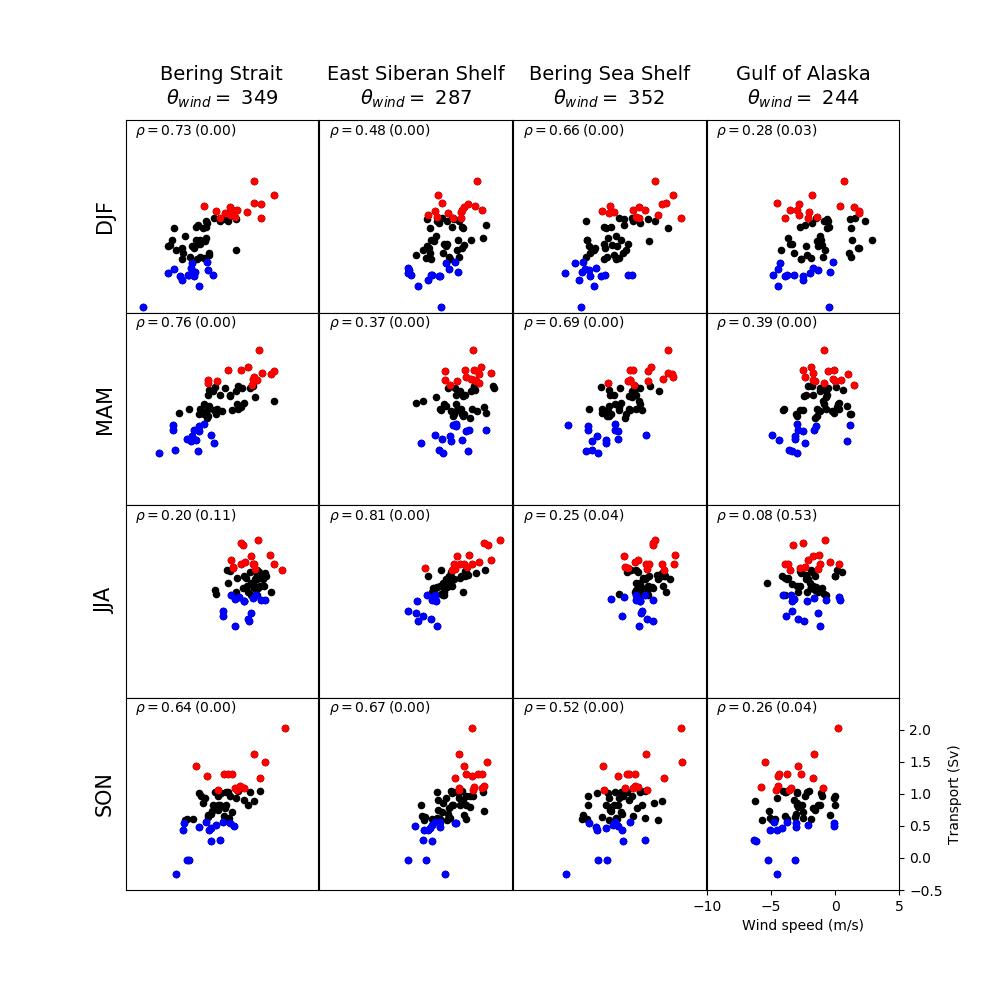

In [17]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), gridspec_kw = {'wspace':0, 'hspace':0})

plot_panel(df_rotated, ax[0,0], 'Bering Strait', 'Transport', 'DJF', hidex=True, hidey=True)
plot_panel(df_rotated, ax[0,1], 'East Siberian Shelf', 'Transport', 'DJF', hidex=True, hidey=True)
plot_panel(df_rotated, ax[0,2], 'Bering Sea Shelf', 'Transport', 'DJF', hidex=True, hidey=True)
plot_panel(df_rotated, ax[0,3], 'Gulf of Alaska', 'Transport', 'DJF', hidex=True, hidey=True)

plot_panel(df_rotated, ax[1,0], 'Bering Strait', 'Transport', 'MAM', hidex=True, hidey=True)
plot_panel(df_rotated, ax[1,1], 'East Siberian Shelf', 'Transport', 'MAM', hidex=True, hidey=True)
plot_panel(df_rotated, ax[1,2], 'Bering Sea Shelf', 'Transport', 'MAM', hidex=True, hidey=True)
plot_panel(df_rotated, ax[1,3], 'Gulf of Alaska', 'Transport', 'MAM', hidex=True, hidey=True)

plot_panel(df_rotated, ax[2,0], 'Bering Strait', 'Transport', 'JJA', hidex=True, hidey=True)
plot_panel(df_rotated, ax[2,1], 'East Siberian Shelf', 'Transport', 'JJA', hidex=True, hidey=True)
plot_panel(df_rotated, ax[2,2], 'Bering Sea Shelf', 'Transport', 'JJA', hidex=True, hidey=True)
plot_panel(df_rotated, ax[2,3], 'Gulf of Alaska', 'Transport', 'JJA', hidex=True, hidey=True)

plot_panel(df_rotated, ax[3,0], 'Bering Strait', 'Transport', 'SON', hidex=True, hidey=True)
plot_panel(df_rotated, ax[3,1], 'East Siberian Shelf', 'Transport', 'SON', hidex=True, hidey=True)
plot_panel(df_rotated, ax[3,2], 'Bering Sea Shelf', 'Transport', 'SON', hidex=True, hidey=True)
plot_panel(df_rotated, ax[3,3], 'Gulf of Alaska', 'Transport', 'SON', hidex=False, hidey=False)
ax[3,3].yaxis.tick_right()
ax[3,3].yaxis.set_label_position('right')

# Add text
fontsize=14
p0 = ax[0,0].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'Bering Strait\n'+r'$\theta_{wind}=$'+'{:4.0f}'.format(360+bst_best_theta), 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
p0 = ax[0,1].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'East Siberan Shelf\n'+r'$\theta_{wind}=$'+'{:4.0f}'.format(360+ess_best_theta), 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
p0 = ax[0,2].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'Bering Sea Shelf\n'+r'$\theta_{wind}=$'+'{:4.0f}'.format(360+bss_best_theta), 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
p0 = ax[0,3].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'Gulf of Alaska\n'+r'$\theta_{wind}=$'+'{:4.0f}'.format(360+gal_best_theta-180.), 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)

p0 = ax[0,0].get_position()
fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, 'DJF', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[1,0].get_position()
fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, 'MAM', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[2,0].get_position()
fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, 'JJA', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[3,0].get_position()
fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, 'SON', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')

fig.savefig('transport_vs_regional_wind_rotated.png')

## Generate non-rotated regional winds

In [18]:
df_raw = pd.DataFrame({'Transport': transport, 
                  'Bering Strait': get_regional_wind(uda, vda, rotation=0., wind='v', region='bering_strait'), 
                  'East Siberian Shelf': get_regional_wind(uda, vda, rotation=0., wind='u', region='east_siberian_sea'),
                  'Bering Sea Shelf': get_regional_wind(uda, vda, rotation=0., wind='v', region='bering_sea_shelf'),
                  'Gulf of Alaska': get_regional_wind(uda, vda, rotation=0., wind='u', region='gulf_of_alaska')})
df_raw.dropna(axis=0, inplace=True)
df_raw.head()

,Bering Sea Shelf,Bering Strait,East Siberian Shelf,Gulf of Alaska,Transport
1990-09-01,-1.894294,-2.074322,0.173427,2.313968,0.60
1990-10-01,-1.621198,-2.476147,0.121908,5.613164,0.62
1990-11-01,-0.220743,-0.523820,-2.422360,5.392169,1.09
1990-12-01,-0.749112,-3.256946,-0.357753,3.132715,0.98
1991-01-01,-3.347468,-4.949245,1.576653,-2.555487,0.51


<IPython.core.display.Javascript object>


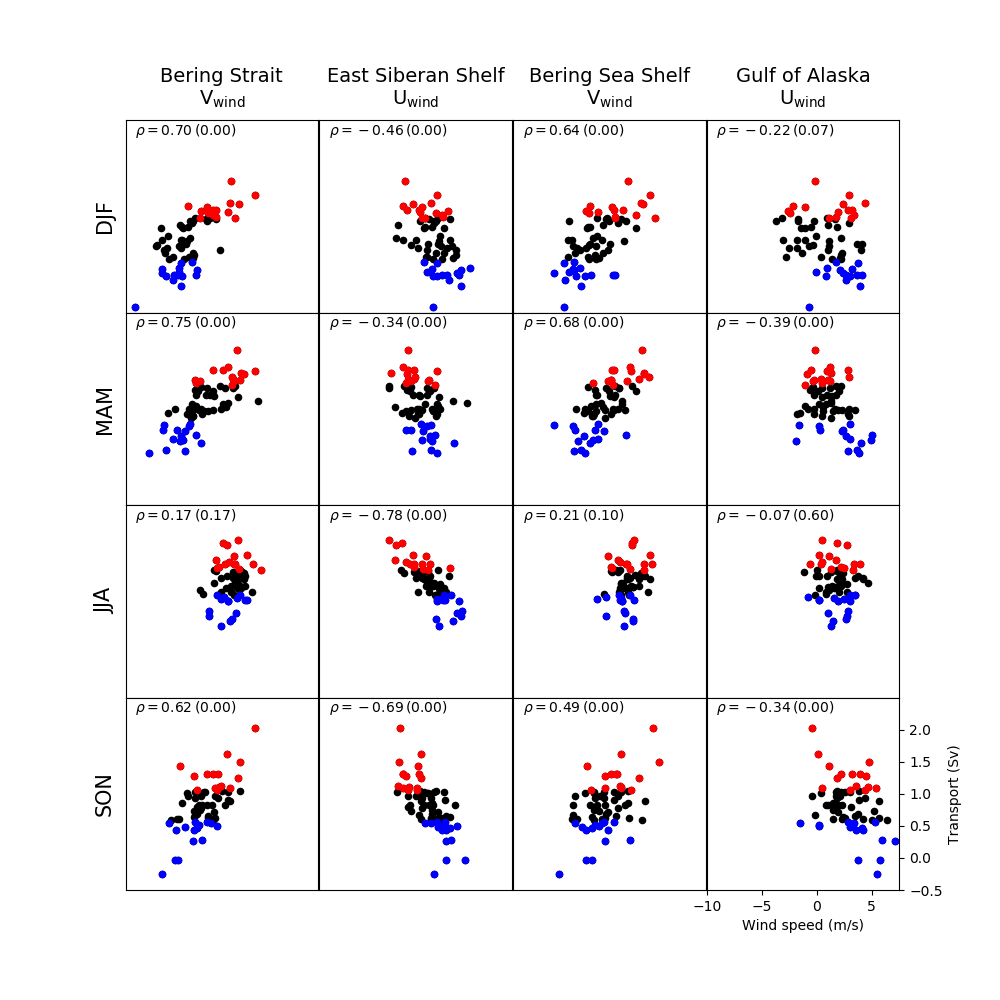

In [19]:
fig, ax = plt.subplots(4, 4, figsize=(10,10), gridspec_kw = {'wspace':0, 'hspace':0})

plot_panel(df_raw, ax[0,0], 'Bering Strait', 'Transport', 'DJF', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[0,1], 'East Siberian Shelf', 'Transport', 'DJF', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[0,2], 'Bering Sea Shelf', 'Transport', 'DJF', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[0,3], 'Gulf of Alaska', 'Transport', 'DJF', hidex=True, hidey=True, xmax=7.5)

plot_panel(df_raw, ax[1,0], 'Bering Strait', 'Transport', 'MAM', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[1,1], 'East Siberian Shelf', 'Transport', 'MAM', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[1,2], 'Bering Sea Shelf', 'Transport', 'MAM', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[1,3], 'Gulf of Alaska', 'Transport', 'MAM', hidex=True, hidey=True, xmax=7.5)

plot_panel(df_raw, ax[2,0], 'Bering Strait', 'Transport', 'JJA', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[2,1], 'East Siberian Shelf', 'Transport', 'JJA', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[2,2], 'Bering Sea Shelf', 'Transport', 'JJA', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[2,3], 'Gulf of Alaska', 'Transport', 'JJA', hidex=True, hidey=True, xmax=7.5)

plot_panel(df_raw, ax[3,0], 'Bering Strait', 'Transport', 'SON', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[3,1], 'East Siberian Shelf', 'Transport', 'SON', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[3,2], 'Bering Sea Shelf', 'Transport', 'SON', hidex=True, hidey=True, xmax=7.5)
plot_panel(df_raw, ax[3,3], 'Gulf of Alaska', 'Transport', 'SON', hidex=False, hidey=False, xmax=7.5)
ax[3,3].yaxis.tick_right()
ax[3,3].yaxis.set_label_position('right')

# Add text
fontsize=14
p0 = ax[0,0].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'Bering Strait\n'+r'$\mathregular{V_{wind}}$', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
p0 = ax[0,1].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'East Siberan Shelf\n'+r'$\mathregular{U_{wind}}$', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
p0 = ax[0,2].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'Bering Sea Shelf\n'+r'$\mathregular{V_{wind}}$', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
p0 = ax[0,3].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'Gulf of Alaska\n'+r'$\mathregular{U_{wind}}$', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)

p0 = ax[0,0].get_position()
fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, 'DJF', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[1,0].get_position()
fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, 'MAM', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[2,0].get_position()
fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, 'JJA', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[3,0].get_position()
fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, 'SON', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')

fig.savefig('transport_vs_regional_wind_raw.png')

<IPython.core.display.Javascript object>


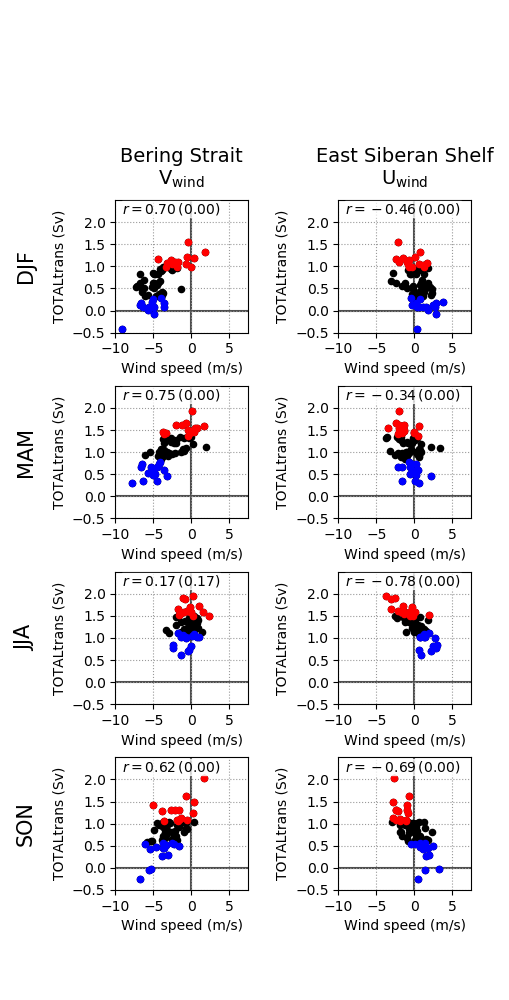

In [40]:
fig, ax = plt.subplots(4, 2, figsize=(5.1,10), gridspec_kw = {'wspace':0.4, 'hspace':0.4, 'top': 0.8, 'right':.95, 'left': 0.2})

plot_panel(df_raw, ax[0,0], 'Bering Strait', 'Transport', 'DJF', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)')
plot_panel(df_raw, ax[0,1], 'East Siberian Shelf', 'Transport', 'DJF', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)')

plot_panel(df_raw, ax[1,0], 'Bering Strait', 'Transport', 'MAM', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)')
plot_panel(df_raw, ax[1,1], 'East Siberian Shelf', 'Transport', 'MAM', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)')

plot_panel(df_raw, ax[2,0], 'Bering Strait', 'Transport', 'JJA', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)')
plot_panel(df_raw, ax[2,1], 'East Siberian Shelf', 'Transport', 'JJA', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)')

plot_panel(df_raw, ax[3,0], 'Bering Strait', 'Transport', 'SON', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)')
plot_panel(df_raw, ax[3,1], 'East Siberian Shelf', 'Transport', 'SON', hidex=False, hidey=False, xmax=7.5, grid=True,
           ylabel='TOTALtrans (Sv)')
#ax[3,1].yaxis.tick_right()
#ax[3,1].yaxis.set_label_position('right')

# Add text
fontsize=14
p0 = ax[0,0].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'Bering Strait\n'+r'$\mathregular{V_{wind}}$', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
p0 = ax[0,1].get_position()
fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, 'East Siberan Shelf\n'+r'$\mathregular{U_{wind}}$', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)

p0 = ax[0,0].get_position()
fig.text(p0.x0-0.15, p0.y0+0.5*p0.height, 'DJF', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[1,0].get_position()
fig.text(p0.x0-0.15, p0.y0+0.5*p0.height, 'MAM', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[2,0].get_position()
fig.text(p0.x0-0.15, p0.y0+0.5*p0.height, 'JJA', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')
p0 = ax[3,0].get_position()
fig.text(p0.x0-0.15, p0.y0+0.5*p0.height, 'SON', 
         horizontalalignment='center', verticalalignment='center', fontsize=15, rotation='vertical')

fig.savefig('transport_vs_regional_wind_raw_for_pub.png')

## Get top 15 transports for each winter months

In [30]:
def get_mean_winds(df, season, N=15):
    
    ssnDict = {'DJF': [12,1,2],
              'MAM': [3,4,5],
              'JJA': [6,7,8],
              'SON': [9,10,11]}
    
    dfTop = df[ df.index.month.isin( ssnDict[season] ) ].sort_values(by='Transport', ascending=False)[:N].mean()
    dfBot = df[ df.index.month.isin( ssnDict[season] ) ].sort_values(by='Transport', ascending=True)[:N].mean()
    
    return pd.merge(dfTop.to_frame(season+' High'), dfBot.to_frame(season+' Low'), 
                    left_index=True, right_index=True).T


In [31]:
hilo_winds = pd.concat( [get_mean_winds(df_raw, 'DJF'),
                         get_mean_winds(df_raw, 'MAM'),
                         get_mean_winds(df_raw, 'JJA'),
                         get_mean_winds(df_raw, 'SON')] )
hilo_winds

,Bering Sea Shelf,Bering Strait,East Siberian Shelf,Gulf of Alaska,Transport
DJF High,-0.311291,-1.542096,-0.405844,1.216250,1.128000
DJF Low,-4.052317,-5.446229,1.384852,2.285466,0.082667
MAM High,0.128121,-0.810306,-1.373977,0.596192,1.531333
MAM Low,-3.267828,-5.169095,-0.235500,2.296657,0.560000
JJA High,0.567319,-0.211105,-1.353588,1.656516,1.651333
JJA Low,-0.190971,-0.680151,1.643024,1.803842,0.923333
SON High,-0.294016,-1.616945,-1.816796,2.839830,1.303333
SON Low,-2.529544,-4.084584,1.303703,3.547444,0.350000


In [32]:
hilo_winds_rotated = pd.concat( [get_mean_winds(df_rotated, 'DJF'),
                                 get_mean_winds(df_rotated, 'MAM'),
                                 get_mean_winds(df_rotated, 'JJA'),
                                 get_mean_winds(df_rotated, 'SON')] )
hilo_winds_rotated

,Bering Sea Shelf,Bering Strait,East Siberian Shelf,Gulf of Alaska,Transport
DJF High,-0.007991,-1.197047,0.593274,-1.453801,1.128000
DJF Low,-3.828282,-5.110527,-1.253556,-2.675657,0.082667
MAM High,0.316392,-0.646621,1.611334,-0.768742,1.531333
MAM Low,-3.060342,-4.896685,0.417638,-2.484704,0.560000
JJA High,0.557704,-0.228442,1.564980,-2.022912,1.651333
JJA Low,-0.296850,-0.801252,-1.545371,-2.212573,0.923333
SON High,-0.291231,-1.262374,1.826506,-3.307484,1.303333
SON Low,-2.504503,-3.793735,-1.185694,-3.727317,0.350000


## Use Monte Carlo sampling to find confidence limits of regional winds

In [33]:
def sample_by_month(df, region, season, n=15, nsample=1000):
    """
    Returns a random sample of 15 month composites
    """
    ssnDict = {'DJF': [12,1,2],
              'MAM': [3,4,5],
              'JJA': [6,7,8],
              'SON': [9,10,11]}
    x = []
    for i in range(nsample):
        x.append(df[df.index.month.isin(ssnDict[season])][region].sample(n=n).mean())
    return x


<IPython.core.display.Javascript object>


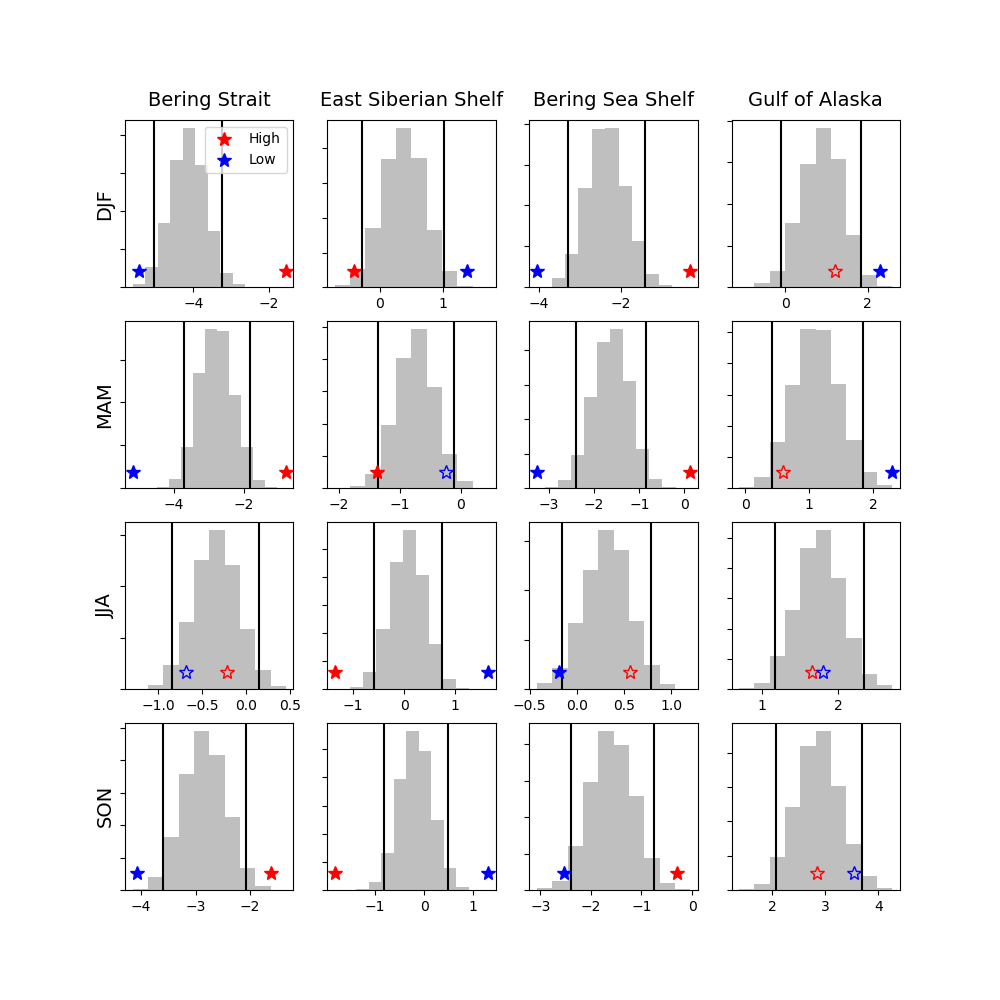

In [34]:
these_regions = ['Bering Strait', 'East Siberian Shelf', 'Bering Sea Shelf', 'Gulf of Alaska']
fig, ax = plt.subplots(4, 4, figsize=(10,10))

for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    for j, region in enumerate(these_regions):
        x = sample_by_month(df_raw, region, season, nsample=5000)
        q = np.percentile(x,[2.5,97.5])

        ax[i,j].hist(x, color='0.75', density=True)
        ax[i,j].axvline(q[0], c='k')
        ax[i,j].axvline(q[1], c='k')
        
        ytop = ax[i,j].get_ylim()[1] # Get upper limit of y-axis to plot markers ar same height
        
        high = hilo_winds[region][season+' High']
        if (high < q[0]) | (high > q[1]):
            markerfacecolor='r'
        else:
            markerfacecolor='0.75'
        ax[i,j].plot(high, 0.1*ytop, '*', markeredgecolor='r', markerfacecolor=markerfacecolor, ms=10, label='High')
        
        low = hilo_winds[region][season+' Low']
        if (low < q[0]) | (low > q[1]):
            markerfacecolor='b'
        else:
            markerfacecolor='0.75'
        ax[i,j].plot(low, 0.1*ytop, '*', markeredgecolor='b', markerfacecolor=markerfacecolor, ms=10, label='Low')
        
        ax[i,j].set_yticklabels([])
        if (i == 0) & (j == 0): ax[i,j].legend()
        #ax[i,j].set_title(region+' '+season)
        
# Add text
fontsize=14
for j, region in enumerate(these_regions):
    p0 = ax[0,j].get_position()
    fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, region, 
             horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
    
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    p0 = ax[i,0].get_position()
    fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, season, 
             horizontalalignment='center', verticalalignment='center', fontsize=fontsize, 
             rotation='vertical')
    
fig.savefig('composite_winds_confidence_limits.raw_winds.png')

<IPython.core.display.Javascript object>


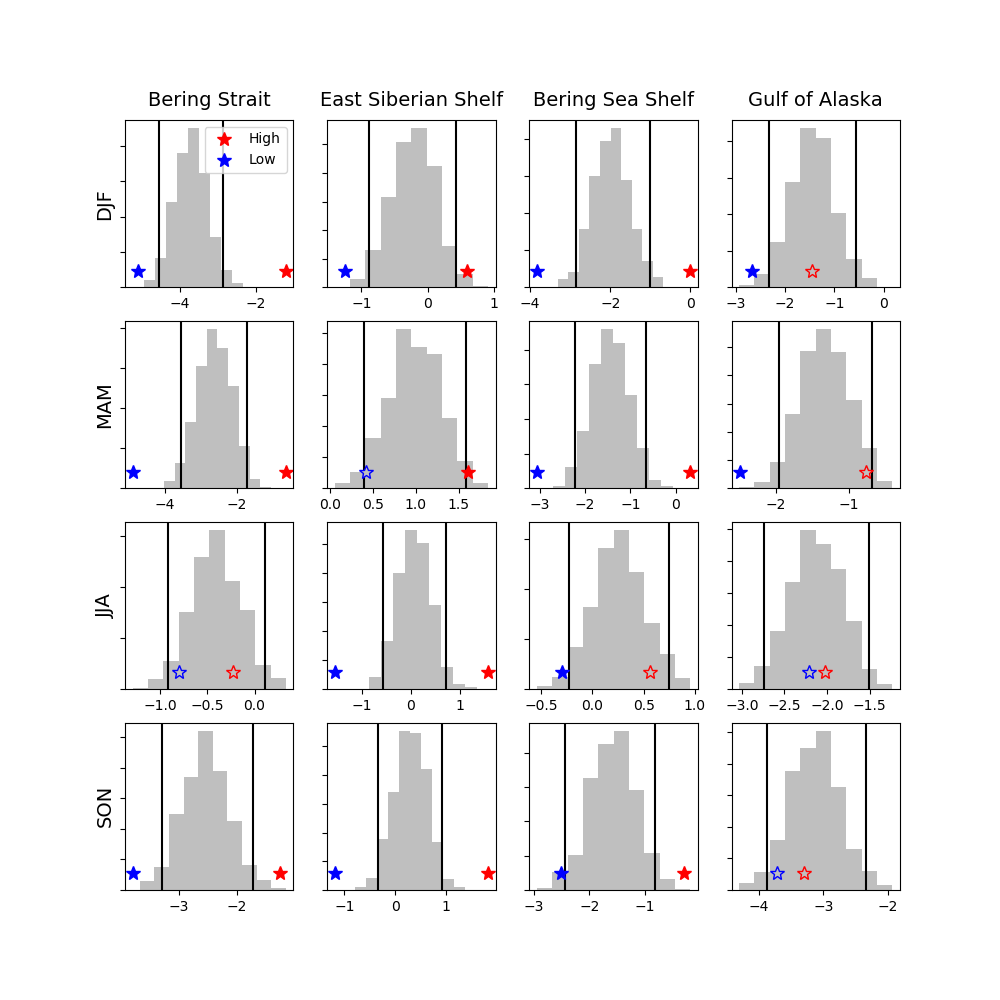

In [35]:
these_regions = ['Bering Strait', 'East Siberian Shelf', 'Bering Sea Shelf', 'Gulf of Alaska']
fig, ax = plt.subplots(4, 4, figsize=(10,10))

for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    for j, region in enumerate(these_regions):
        x = sample_by_month(df_rotated, region, season, nsample=1000)
        q = np.percentile(x,[2.5,97.5])

        ax[i,j].hist(x, color='0.75', density=True)
        ax[i,j].axvline(q[0], c='k')
        ax[i,j].axvline(q[1], c='k')
        
        ytop = ax[i,j].get_ylim()[1] # Get upper limit of y-axis to plot markers ar same height
        
        high = hilo_winds_rotated[region][season+' High']
        if (high < q[0]) | (high > q[1]):
            markerfacecolor='r'
        else:
            markerfacecolor='0.75'
        ax[i,j].plot(high, 0.1*ytop, '*', markeredgecolor='r', markerfacecolor=markerfacecolor, ms=10, label='High')
        
        low = hilo_winds_rotated[region][season+' Low']
        if (low < q[0]) | (low > q[1]):
            markerfacecolor='b'
        else:
            markerfacecolor='0.75'
        ax[i,j].plot(low, 0.1*ytop, '*', markeredgecolor='b', markerfacecolor=markerfacecolor, ms=10, label='Low')
        
        ax[i,j].set_yticklabels([])
        if (i == 0) & (j == 0): ax[i,j].legend()
        #ax[i,j].set_title(region+' '+season)
        
# Add text
fontsize=14
for j, region in enumerate(these_regions):
    p0 = ax[0,j].get_position()
    fig.text(p0.x0+0.5*p0.width, p0.y1+0.01, region, 
             horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize)
    
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    p0 = ax[i,0].get_position()
    fig.text(p0.x0-0.02, p0.y0+0.5*p0.height, season, 
             horizontalalignment='center', verticalalignment='center', fontsize=fontsize, 
             rotation='vertical')
    
fig.savefig('composite_winds_confidence_limits.rotated_winds.png')

## Get wind speeds for case studies

In [42]:
case_study_month = ['2007-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2005-11-01']
case_study_winds = df_raw[df_raw.index.isin(case_study_month)]
case_study_winds[['Bering Strait','East Siberian Shelf']]

,Bering Strait,East Siberian Shelf
2005-11-01,-6.686251,0.435013
2007-09-01,0.354541,-2.805610
2016-10-01,1.725216,-2.631122
2016-11-01,-3.273889,0.245233
2016-12-01,-0.489529,0.156136


## Get percentiles for monthly regional winds
I use wind speeds from months adjacent to month of interest, as well as the month of interest to calculate distribution

In [59]:
def get_month_list(case_study):
    result = [np.mod(dt.datetime.strptime(case_study,'%Y-%m-%d').month+im,12) for im in [-1,0,1]]
    return [m if m != 0 else 12 for m in result]
    
for case_study in case_study_month:
    month = get_month_list(case_study)
    p_bst = np.percentile(df_raw[df_raw.index.month.isin(month)]['Bering Strait'],[2.5,97.5])
    p_ess = np.percentile(df_raw[df_raw.index.month.isin(month)]['East Siberian Shelf'],[2.5,97.5])
    if ((case_study_winds.loc[case_study,'Bering Strait'] < p_bst[0]) or 
        (case_study_winds.loc[case_study,'Bering Strait'] > p_bst[1])):
        s_bst = '*'
    else:
        s_bst = ' '
    if ((case_study_winds.loc[case_study,'East Siberian Shelf'] < p_ess[0]) or 
        (case_study_winds.loc[case_study,'East Siberian Shelf'] > p_ess[1])):
        s_ess = '*'
    else:
        s_ess = ' '
          
    print ('{:s} Bering Strait: {:4.1f}{:s} ({:4.1f},{:4.1f})  East Siberian Shelf: {:4.1f}{:s} ({:4.1f},{:4.1f})'.format(
                                                                           case_study,
                                                                           case_study_winds.loc[case_study,'Bering Strait'],
                                                                           s_bst,
                                                                           p_bst[0], p_bst[1],
                                                                           case_study_winds.loc[case_study,'East Siberian Shelf'],
                                                                           s_ess,
                                                                           p_ess[0], p_ess[1],
                                                                           ))

2007-09-01 Bering Strait:  0.4  (-5.4, 1.0)  East Siberian Shelf: -2.8* (-2.7, 2.9)
2016-10-01 Bering Strait:  1.7* (-5.9, 0.4)  East Siberian Shelf: -2.6  (-2.8, 2.4)
2016-11-01 Bering Strait: -3.3  (-6.6,-0.2)  East Siberian Shelf:  0.2  (-2.7, 2.1)
2016-12-01 Bering Strait: -0.5* (-6.7,-0.6)  East Siberian Shelf:  0.2  (-2.6, 2.9)
2005-11-01 Bering Strait: -6.7* (-6.6,-0.2)  East Siberian Shelf:  0.4  (-2.7, 2.1)


In [60]:
df_raw.tail()

,Bering Sea Shelf,Bering Strait,East Siberian Shelf,Gulf of Alaska,Transport
2017-02-01,-2.162873,-3.903602,2.164553,2.136025,0.35
2017-03-01,-2.049226,-0.686954,3.448261,1.296122,1.09
2017-04-01,-1.348810,-3.280695,-1.638179,-0.386759,1.44
2017-05-01,-1.107860,-3.699919,-1.982239,0.997575,1.45
2017-06-01,0.269393,-0.942641,0.093357,-0.595756,1.58


## Mean winds

In [127]:
bigDf.mean()

Transport                 0.950913
V(Bering Strait)         -2.549238
U(East Siberian Shelf)   -0.116406
U(Bering Sea Shelf)      -0.799732
U(Gulf of Alaska)         1.664992
dtype: float64

## Plot wind vectors

<IPython.core.display.Javascript object>


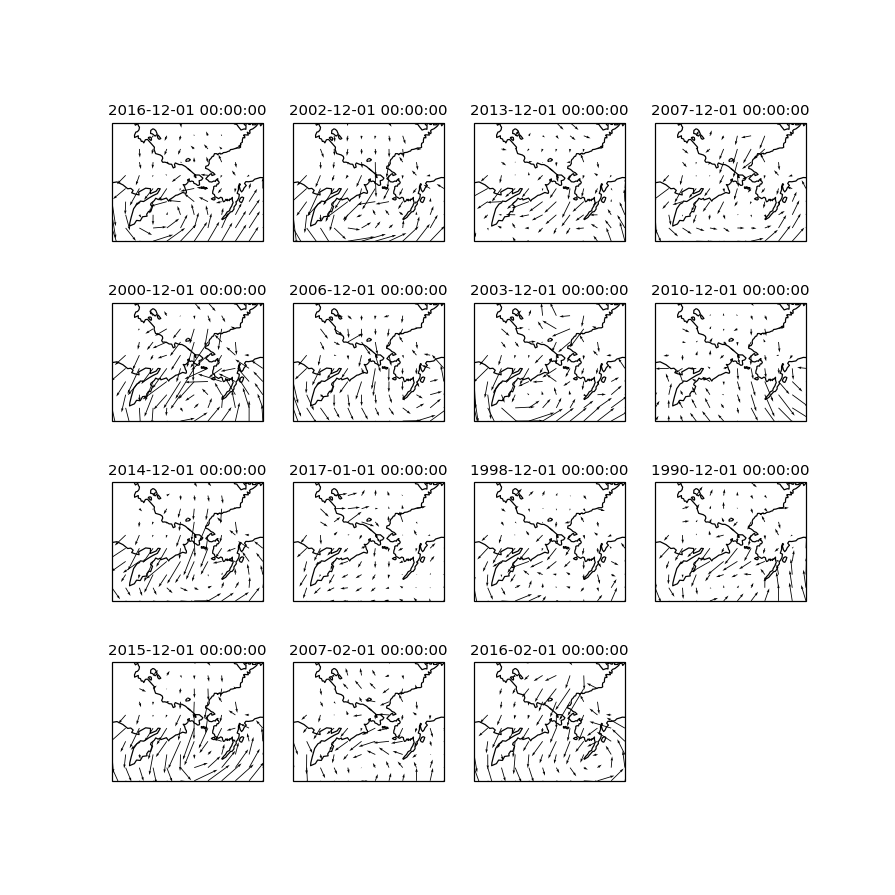

In [284]:
plot_winds(djfHigh.index, uda, vda)

In [295]:
djfHigh['vBST'] = vda_bst.sel(time=djfHigh.index.values)
djfHigh['uBST'] = uda_bst.sel(time=djfHigh.index.values)

djfHigh

,Transport,vBST,uBST
date,,,
2016-12-01,7.5,-0.602192,-2.931665
2002-12-01,5.3,-5.210704,-3.018209
2013-12-01,4.9,-2.737833,-0.944302
2007-12-01,4.8,-2.091707,-2.516546
2000-12-01,3.4,-4.625658,-6.965779
2006-12-01,2.2,-5.488499,-0.801883
2003-12-01,2.0,-2.503607,-2.099372
2010-12-01,1.8,-4.650892,-1.296956
2014-12-01,1.7,-7.276565,-4.181591


## Find 10% of lowest fluxes

In [146]:
DJF_HighDf = v10m_bst.sel(time=transportHigh.index.values).to_dataframe(name='V_BST')
DJF_HighDf['Transport'] = transportHigh
DJF_HighDf['U_BST'] = u10m_bst.sel(time=transportHigh.index.values)
DJF_HighDf['V_ESS'] = v10m_ess.sel(time=transportHigh.index.values)
DJF_HighDf['U_ESS'] = u10m_ess.sel(time=transportHigh.index.values)
DJF_HighDf['V_BSS'] = v10m_bss.sel(time=transportHigh.index.values)
DJF_HighDf['U_BSS'] = u10m_bss.sel(time=transportHigh.index.values)
DJF_HighDf

,V_BST,Transport,U_BST,V_ESS,U_ESS,V_BSS,U_BSS
time,,,,,,,
2016-10-01,2.013043,56.4,-4.509831,-2.467320,-2.452156,2.013043,-4.509831
2007-09-01,0.403896,32.8,-3.096894,0.643523,-1.446837,0.403896,-3.096894
2011-10-01,-3.066023,26.2,-1.535986,0.304343,-1.531043,-3.066023,-1.535986
2004-10-01,-2.046422,25.3,-2.123888,-1.326803,-0.593873,-2.046422,-2.123888
2014-11-01,-0.896596,24.5,-4.616610,0.008539,-0.495916,-0.896596,-4.616610
2014-09-01,-1.916541,24.4,0.702120,1.333297,-0.316081,-1.916541,0.702120
2005-09-01,-0.605080,23.9,-3.012336,0.409072,-0.572258,-0.605080,-3.012336
2010-09-01,0.211384,22.4,-1.602417,-1.009890,-0.705589,0.211384,-1.602417
2015-10-01,-3.621282,22.1,-2.505197,0.762253,0.343785,-3.621282,-2.505197


In [147]:
DJF_HighDf.mean()

V_BST        -1.863977
Transport    25.146667
U_BST        -1.818590
V_ESS        -0.091801
U_ESS        -1.123157
V_BSS        -1.863977
U_BSS        -1.818590
dtype: float64

## Find top 10% of fluxes

In [81]:
thisTime = heat.sort_values(ascending=False)[0:n10].index.values
bssTopDf = v10m_bs.sel(time=thisTime).to_dataframe(name='V10M')
bssTopDf['HeatFlux'] = heat.sort_values(ascending=False)[0:n10]
bssTopDf

,V10M,HeatFlux
time,,
2016-10-01,2.013043,56.4
2015-07-01,-0.941747,40.1
2007-09-01,0.403896,32.8
2015-08-01,-0.337457,31.6
2011-07-01,-0.102097,30.9
2011-08-01,-1.601268,30.4
2017-06-01,-1.117234,30.3
2007-08-01,0.337001,29.2
2007-07-01,0.446218,28.7


In [148]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [263]:

    print (i+1, thisMonth)

1 2016-10-01 00:00:00
2 2007-09-01 00:00:00
3 2011-10-01 00:00:00
4 2004-10-01 00:00:00
5 2014-11-01 00:00:00
6 2014-09-01 00:00:00
7 2005-09-01 00:00:00
8 2010-09-01 00:00:00
9 2015-10-01 00:00:00
10 2006-10-01 00:00:00
11 1998-09-01 00:00:00
12 2004-09-01 00:00:00
13 2002-09-01 00:00:00
14 2013-09-01 00:00:00
15 2010-10-01 00:00:00


In [66]:
mask = xr.DataArray(np.array([[1,1,0],[1,1,1]]), [('lat', np.arange(2)), ('lon', np.arange(3))])
mask

<xarray.DataArray (lat: 2, lon: 3)>
array([[1, 1, 0],
       [1, 1, 1]])
Coordinates:
  * lat      (lat) int32 0 1
  * lon      (lon) int32 0 1 2

In [50]:
b = xr.DataArray(np.arange(12).reshape(2,2,3), [('time', np.arange(2)), ('lat', np.arange(2)), ('lon', np.arange(3))])
b

<xarray.DataArray (time: 2, lat: 2, lon: 3)>
array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])
Coordinates:
  * time     (time) int32 0 1
  * lat      (lat) int32 0 1
  * lon      (lon) int32 0 1 2

In [68]:
b.where(mask == 1)

<xarray.DataArray (time: 2, lat: 2, lon: 3)>
array([[[ 0.,  1., nan],
        [ 3.,  4.,  5.]],

       [[ 6.,  7., nan],
        [ 9., 10., 11.]]])
Coordinates:
  * time     (time) int32 0 1
  * lat      (lat) int32 0 1
  * lon      (lon) int32 0 1 2

In [159]:
print ('{:4.1f}'.format(-0.04))

-0.0


In [158]:
np.round(-0.04,1)

-0.0

In [ ]:
windd = {'DJF': {'hi': [-1.5, -0.4, -0.3], 'lo': [-5.5,  1.4, -4.1],
                         'hisig': [True,True,True], 'losig': [True,True,True]},
                 'MAM': {'hi': [-0.8, -1.4,  0.1], 'lo': [-5.2, -0.2, -3.3],
                         'hisig': [True,True,True], 'losig': [True,False,True]},
                 'JJA': {'hi': [-0.2, -1.4,  0.6], 'lo': [-0.7,  1.6, -0.2],
                         'hisig': [False,True,False], 'losig': [False,True,True]},
                 'SON': {'hi': [-1.6, -1.8, -0.3], 'lo': [-4.1,  1.3, -2.5],
                         'hisig': [True,True,True], 'losig': [True,True,True]}}

In [ ]:
windd['DJF']['hi']